In [85]:
import time
from glob import glob

In [76]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.maskers import nifti_spheres_masker
from nilearn.signal import clean
from nilearn.masking import apply_mask, _unmask_3d, compute_brain_mask
from nilearn.image import load_img, new_img_like
from nilearn.glm.first_level import spm_hrf, glover_hrf


def round_cust(x):
    return np.floor(x + 0.49)


def trlocked_events(events_path: str, onsets_column: str, trial_name: str,
                    bold_tr: float, bold_vols: int, separator: str = '\t'):
    """
    Loads behavior data, creates and merges into a TR (rounded) dataframe to match length of BOLD. Trial onsets are
    matched to nearby TR using rounding when acquisition is not locked to TR.

    Parameters:
        events_path (str): Path to the events data files for given subject/run.
        onsets_column (str): Name of the column containing onset times for the event/condition.
        trial_name (str): Name of the column containing condition/trial labels.
        bold_tr (int): TR acquisition of BOLD in seconds.
        bold_vols (int): Number of time points for BOLD acquisition
        separator (str): Separator used in the events data file, default = '\t'.
    Returns:
        pandas.DataFrame: Merged dataframe with time index and events data for each event + TR delays.
    """
    if not os.path.exists(events_path):
        raise FileNotFoundError(f"File '{events_path}' not found.")

    beh_df = pd.read_csv(events_path, sep=separator)

    missing_cols = [col for col in [onsets_column, trial_name] if col not in beh_df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns: {', '.join(missing_cols)}")

    beh_df = beh_df[[onsets_column, trial_name]]
    
    try:
        beh_df["TimePoint"] = round_cust(
            beh_df[onsets_column] / bold_tr).astype(int)  # Per Elizabeth, avoids bakers roundings in .round()
    except Exception as e:
        print("An error occurred:", e, "Following file included NaN, dropped.", events_path)
        beh_df.dropna(inplace=True) # cannot perform operations on missing information
        beh_df["TimePoint"] = round_cust(beh_df[onsets_column] / bold_tr).astype(int)

    time_index = pd.RangeIndex(start=0, stop=bold_vols, step=1)
    time_index_df = pd.DataFrame(index=time_index)
    # Merge behavior data with time index
    merged_df = pd.merge(time_index_df, beh_df, how='left', left_index=True, right_on='TimePoint')

    if len(merged_df) != bold_vols:
        raise ValueError(f"Merged data length ({len(merged_df)}) doesn't match volumes ({bold_vols}).")

    return merged_df


def extract_time_series_values(behave_df: pd.DataFrame, time_series_array: np.ndarray, delay: int):
    """
    Extracts time series data from the provided timeseries BOLD area for associated behavioral data
    that is acuiqred from trlocked_events w/ specified delay

    Parameters:
        behave_df (pandas.DataFrame): DataFrame containing behavioral data with a 'TimePoint' column
            indicating the starting point for each time series extraction.
        time_series_array (ndarray): Numpy Array containing time series data.
        delay (int): Number of data points to include in each extracted time series.

    Returns:
        np.ndarray: Array containing the extracted time series data for each time point in the behavioral DataFrame.
            Each row corresponds to a time point, and each column contains the extracted time series data.
    """
    extracted_series_list = []
    for row in behave_df['TimePoint']:
        start = int(row)
        end = start + delay
        extracted_series = time_series_array[start:end]
        if len(extracted_series) < delay:  # Check if extracted series is shorter than delay
            extracted_series = np.pad(extracted_series, ((0, delay - len(extracted_series)), (0, 0)), mode='constant')
        extracted_series_list.append(extracted_series)
    return np.array(extracted_series_list, dtype=object)


def extract_time_series(bold_paths: list, roi_type: str, high_pass_sec: int = None, roi_mask: str = None,
                        roi_coords: tuple = None, radius_mm: int = None, bold_tr: float = None, detrend=True,
                        fwhm_smooth: float = None):
    """
    For each BOLD path, extract timeseries for either a specified mask or ROI coordinate. Mask and coordinate should be
    in same space/affine as BOLD data. Function leverages NiftiLabelsMasker (mask path) NiftiSpheresMasker (coordinates)
    to achieve this.

    Parameters:
        bold_paths (list): List of paths to subjects (list should match order of subs/runs/tasks for events file list).
        roi_type (str): Type of ROI ('mask' or 'coords').
        high_pass_sec (int): High-pass filter to use, in seconds. Used to convert to filter freq using 1/secs.
        roi_mask (str or None): Path to the ROI mask image (required if roi_type is 'mask').
        roi_coords (tuple or None): Coordinates (x,y,z) for the sphere center (required if roi_type is 'coords').
        radius_mm (int or None): Radius of the sphere in mm (required if roi_type is 'coords').
        bold_tr (float or None): TR value for acquisition of BOLD data.
        detrend: True/False, whether to use Nilearn's detrend function.
        fwhm_smooth (float or None): FWHM for spatial smoothing of data.

    Returns:
        list: List of time series for provided subjects/runs.
    """
    roi_options = ['mask', 'coords']

    if roi_type not in roi_options:
        raise ValueError("Invalid ROI type. Choose 'mask' or 'coords'.")

    if roi_type == 'mask':
        roi_series_list = []

        # Iterate over each path in bold_paths
        for bold_path in bold_paths:
            img = [load_img(i) for i in [bold_path, roi_mask]]
            assert img[0].shape[0:3] == img[1].shape, 'images of different shape, BOLD {} and ROI {}'.format(
                img[0].shape, img[1].shape)
            # Mask data by ROI and smooth and then clean data
            masked_data = apply_mask(bold_path, roi_mask, smoothing_fwhm=fwhm_smooth)
            clean_timeseries = clean(masked_data, standardize='psc', detrend=detrend,
                                     high_pass=1 / high_pass_sec if high_pass_sec is not None else None)

            # get avg at volumes across voxels, return a (volumnes,1) array
            time_series_avg = np.mean(clean_timeseries, axis=1)[:, None]
            roi_series_list.append(time_series_avg)

        return roi_series_list

    elif roi_type == 'coords':
        coord_series_list = []
        wb_mask = compute_brain_mask(bold_paths[0])

        for bold_path in bold_paths:
            _, roi = nifti_spheres_masker._apply_mask_and_get_affinity(
                seeds=[roi_coords], niimg=None, radius=radius_mm,
                allow_overlap=False, mask_img=wb_mask)
            coord_mask = _unmask_3d(X=roi.toarray().flatten(), mask=wb_mask.get_fdata().astype(bool))
            coord_mask = new_img_like(wb_mask, coord_mask, wb_mask.affine)

            img = [load_img(i) for i in [bold_path, coord_mask]]
            assert img[0].shape[0:3] == img[1].shape, 'images of different shape, BOLD {} and ROI {}'.format(
                img[0].shape[0:3], img[1].shape)
            # Mask data by ROI and smooth and then clean data
            masked_data = apply_mask(bold_path, coord_mask, smoothing_fwhm=fwhm_smooth)
            clean_timeseries = clean(masked_data, standardize='psc', detrend=detrend,
                                     high_pass=1 / high_pass_sec if high_pass_sec is not None else None)

            # get avg at volumes across voxels, return a (volumnes,1) array
            time_series_avg = np.mean(clean_timeseries, axis=1)[:, None]
            coord_series_list.append(time_series_avg)
        return coord_series_list, coord_mask

    else:
        print(f'roi_type: {roi_type}, is not in [{roi_options}]')


def extract_postcue_trs_for_conditions(events_data: list, onset: str, trial_name: str,
                                       bold_tr: float, bold_vols: int, time_series: np.ndarray,
                                       conditions: list, tr_delay: int):
    """
    Extract TR coinciding with condition onset, plus TRs for specified delay for each file. Save this to a pandas
    dataframe (long) with associated Mean Signal value, for each subject, trial of condition and cue across the range
    of TRs (1 to TR delay)

    Parameters:
        events_data (list): List of paths to behavioral data files (list should match order for
        subs/runs/tasks as bold file list).
        onset (str): Name of the column containing onset values in the behavioral data.
        trial_name (str): Name of the column containing condition values in the behavioral data.
        bold_tr (int): TR for acquisiton of BOLD data.
        bold_vols (int): Number of volumes for BOLD.
        time_series (numpy.ndarray): numpy array of time series data.
        conditions (list): List of cue conditions to iterate over, min 1.
        tr_delay (int): Number of TRs to serve as delay (post onset)

    Returns:
        pd.DataFrame: DataFrame containing mean signal intensity values, subject labels,
            trial labels, TR values, and cue labels for all specified conditions.
    """
    dfs = []
    for cue in conditions:
        cue_dfs = [] # creating separate cue dfs to accomodate different number of trials for cue types
        sub_n = 0
        for index, beh_path in enumerate(events_data):
            subset_df = trlocked_events(events_path=beh_path, onsets_column=onset,
                                        trial_name=trial_name, bold_tr=bold_tr, bold_vols=bold_vols, separator='\t')
            trial_type = subset_df[subset_df[trial_name] == cue]
            out_trs_array = extract_time_series_values(behave_df=trial_type, time_series_array=time_series[index],
                                                       delay=tr_delay)
            sub_n = sub_n + 1  # subject is equated to every event file N, subj n = 1 to len(events_data)

            # nth trial, list of TRs
            for n_trial, trs in enumerate(out_trs_array):
                num_delay = len(trs)  # Number of TRs for the current trial
                if num_delay != tr_delay:
                    raise ValueError(f"Mismatch between tr_delay ({tr_delay}) and number of delay TRs ({num_delay})")

                reshaped_array = np.array(trs).reshape(-1, 1)
                df = pd.DataFrame(reshaped_array, columns=['Mean_Signal'])
                df['Subject'] = sub_n
                df['Trial'] = n_trial + 1
                tr_values = np.arange(1, tr_delay + 1)
                df['TR'] = tr_values
                cue_values = [cue] * num_delay
                df['Cue'] = cue_values
                cue_dfs.append(df)

        dfs.append(pd.concat(cue_dfs, ignore_index=True))

    return pd.concat(dfs, ignore_index=True)


def plot_responses(df, tr: int, delay: int, style: str = 'white', plt_hrf: str = None, save_path: str = None,
                   show_plot: bool = True, ylim: tuple = (-1, 1)):
    """
    Plot the BOLD reponse (Mean_Signal ~ TR) across specified delay for Cues.
    Alpha is is 0.1 with n = 1000 bootstraps for standard errors.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        tr (int): TR value in seconds.
        delay (int): Delay value.
        style (str): whether to plot white or white_grid
        plt_hrf (str): overlay on plot either the SPM or Glover HRF from Nilearn.
        save_path (str): Path and extension to save plot, optional default None.
        show_plot (bool): Whether to show plot in window, optional with default True.
        ylim (tuple): y-axis limits, default is tuple (-1, 1).
    """
    plt.figure(figsize=(10, 8), dpi=300)
    if style not in ['white', 'whitegrid']:
        raise ValueError("Style should be white or whitegrid, provided:", style)

    sns.set(style=style, font='DejaVu Serif')

    sns.lineplot(x="TR", y="Mean_Signal", hue="Cue", style="Cue", palette="Set1",
                 errorbar='se', err_style="band", err_kws={'alpha': 0.1}, n_boot=1000,
                 legend="brief", data=df)
    
    if plt_hrf in ['spm','glover']:
        if plt_hrf == 'spm':
            hrf = spm_hrf(tr=tr, oversampling=1, time_length=delay*2, onset=0)
            time_points = np.arange(1, delay + 1, 1)
            plt.plot(time_points, hrf, linewidth=2, linestyle='--',label='SPM HRF', color='black')
        if plt_hrf == 'glover':
            hrf = glover_hrf(tr=tr, oversampling=1, time_length=delay*2, onset=0)
            time_points = np.arange(1, delay + 1, 1)
            plt.plot(time_points, hrf, linewidth=2, linestyle='--',label='Glover HRF', color='black')

    # Set labels and title
    plt.xlabel(f'Seconds (TR: {tr} sec)')
    plt.ylabel('Avg. Signal Change')
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(0, delay)
    plt.xticks(np.arange(0, delay, 1),
               [f'{round((i * tr)-tr, 1)}' for i in range(0, delay)],
               rotation=45)

    # Show legend
    plt.legend(loc='upper right')

    # Check if save_path is provided
    if save_path:
        # Get the directory path from save_path
        directory = os.path.dirname(save_path)
        # Check if directory exists, if not, create it
        if not os.path.exists(directory):
            os.makedirs(directory)
        # Save plot
        plt.savefig(save_path)

    # Show plot if show_plot is True
    if not show_plot:
        plt.close()

In [87]:
# set paths
session="baselineYear1Arm1"
data_dir=f'/scratch.global/mdemiden/task_byscanner'
id_list= f'/home/feczk001/mdemiden/analyses/abcd_timelocked_trbold/scripts/cluster/subj_ids/n50_baseline_{scanner}.tsv'
roi_dir = 'home/feczk001/mdemiden/analyses/abcd_timelocked_trbold/scripts/roi_masks'

# set values
left_vs=(-10,8,-10)
right_vs=(10,8,-8)
left_motor_neurosynth = (-38,-22,56)
left_visual_neurosynth = (-6,-90,-2)

fwhm_smooth=4 # from 2021 knutson paper
sphere=8 # from 2021 knutson paper
filter_freq=90 #90 sec from 2021 Knutson paper
onset_time='Cue.OnsetTime'
cond_type='Condition'
cue='LgReward'
tr=.8
volumes=403
task='MID'

In [78]:
os.listdir(data_dir)

['ge', 'philips', 'siemens']

# GE TR-by-TR

In [63]:
ge_dat=os.path.join(data_dir,'ge')
run = '01'
n = 50
# select paths
ge_bold=glob(f'{ge_dat}/**/ses-{session}/func/*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
ge_beh=glob(f'{ge_dat}/**/ses-{session}/func/*_run-{run}_events.tsv')
len(ge_bold),len(ge_beh)

(50, 50)

In [64]:
start = time.time()
subset_paths = ge_bold[0:n]
time_series_ge, mask_coord = extract_time_series(bold_paths=subset_paths, roi_type='coords', 
                                              
                                              roi_coords=left_motor_neurosynth,
                                              
                                              radius_mm=sphere,bold_tr=tr,fwhm_smooth=fwhm_smooth, 
                                              high_pass_sec=filter_freq,detrend=True)
print(f'runtime: {((time.time())-start)/60}')

runtime: 22.020684878031414


In [44]:
np.array(time_series_ge).shape

(25, 403, 1)

In [65]:
beh_subset = ge_beh[0:n]

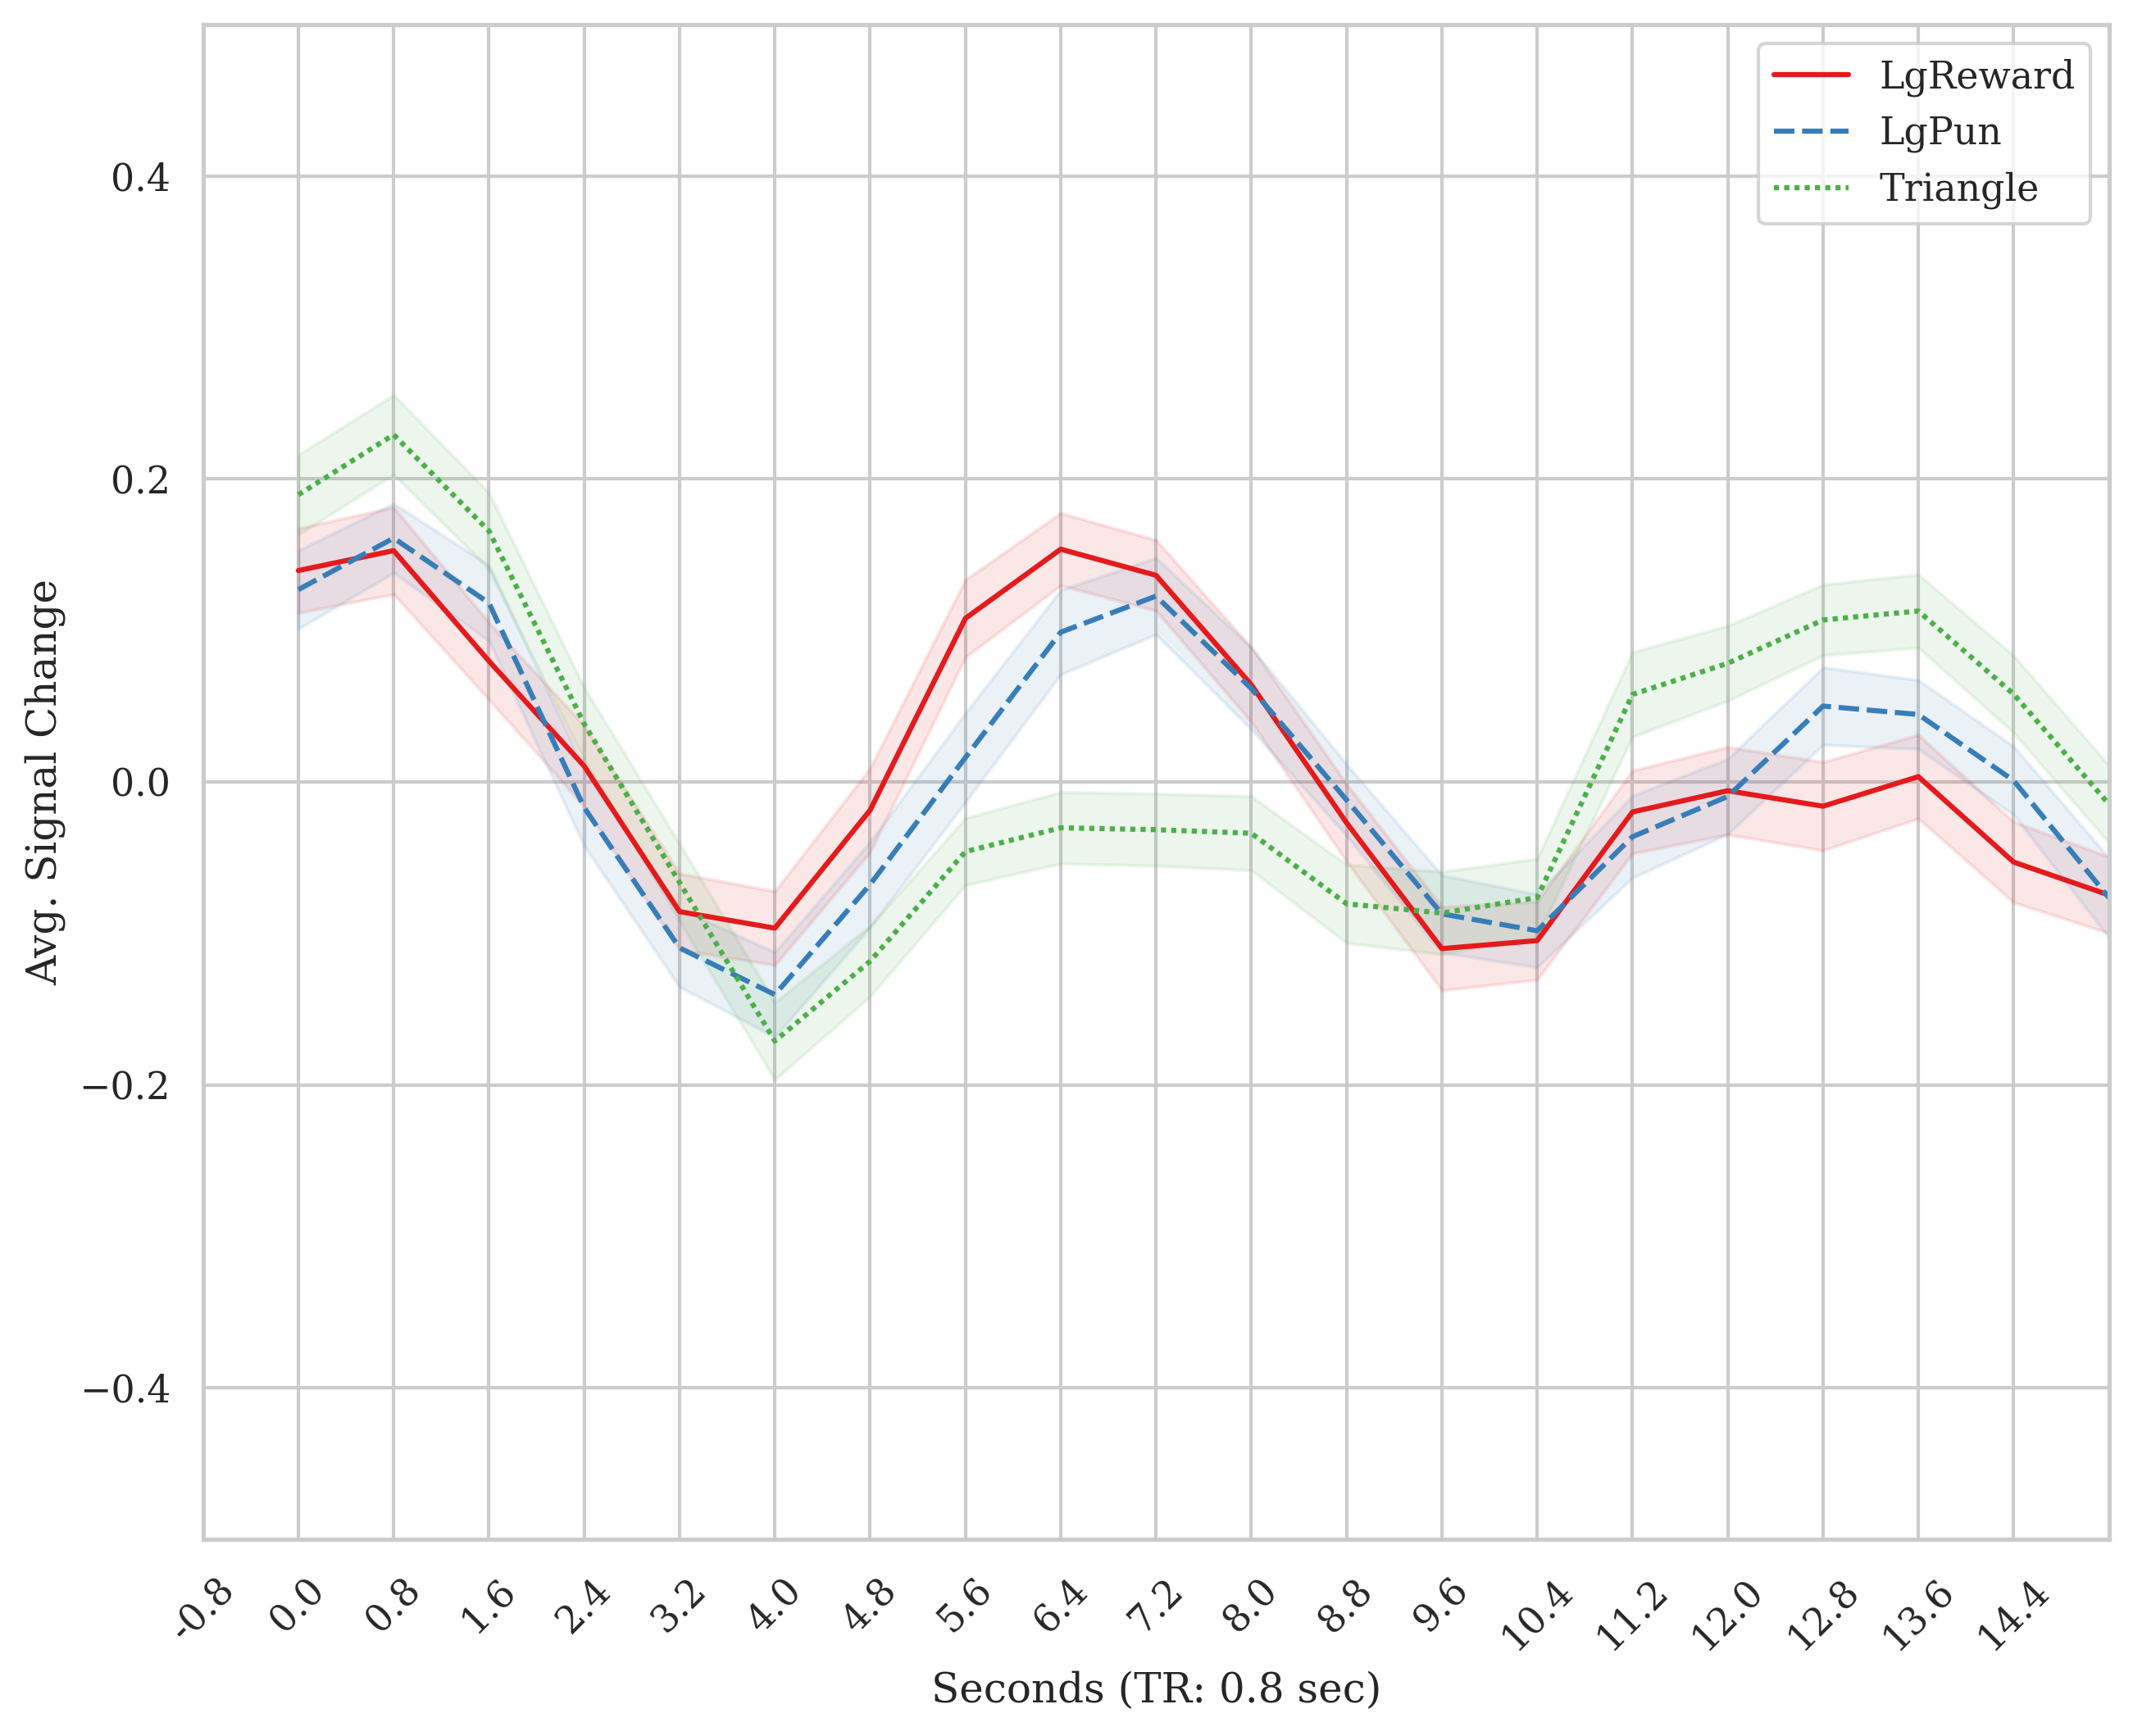

In [66]:
conditions = ['LgReward','LgPun', 'Triangle']
delay=20
dfs = []
df_ge = extract_postcue_trs_for_conditions(events_data=beh_subset, onset=onset_time, trial_name=cond_type,
                                        bold_tr=tr, bold_vols=volumes, conditions=conditions, tr_delay=delay, 
                                        time_series=time_series_ge)
plot_responses(df=df_ge,tr=tr, delay=delay, save_path=None,style='whitegrid', 
                   show_plot=True, ylim=(-.5, .5), plt_hrf = None)

# SIEMENS TR-by-TR

In [68]:
siemens_dat=os.path.join(data_dir,'siemens')
run = '01'
n = 50
# select paths
siemens_bold=glob(f'{siemens_dat}/**/ses-{session}/func/*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
siemens_beh=glob(f'{siemens_dat}/**/ses-{session}/func/*_run-{run}_events.tsv')
len(siemens_bold),len(siemens_beh)

(50, 50)

In [69]:
start = time.time()
subset_paths = siemens_bold[0:n]
time_series_simens, mask_coord = extract_time_series(bold_paths=subset_paths, roi_type='coords', 
                                              
                                              roi_coords=left_motor_neurosynth,
                                              
                                              radius_mm=sphere,bold_tr=tr,fwhm_smooth=fwhm_smooth,
                                              high_pass_sec=filter_freq,detrend=True)
print(f'runtime: {((time.time())-start)/60}')

runtime: 22.464444295565286


In [70]:
np.array(time_series_simens).shape

(50, 403, 1)

In [71]:
beh_subset = siemens_beh[0:n]

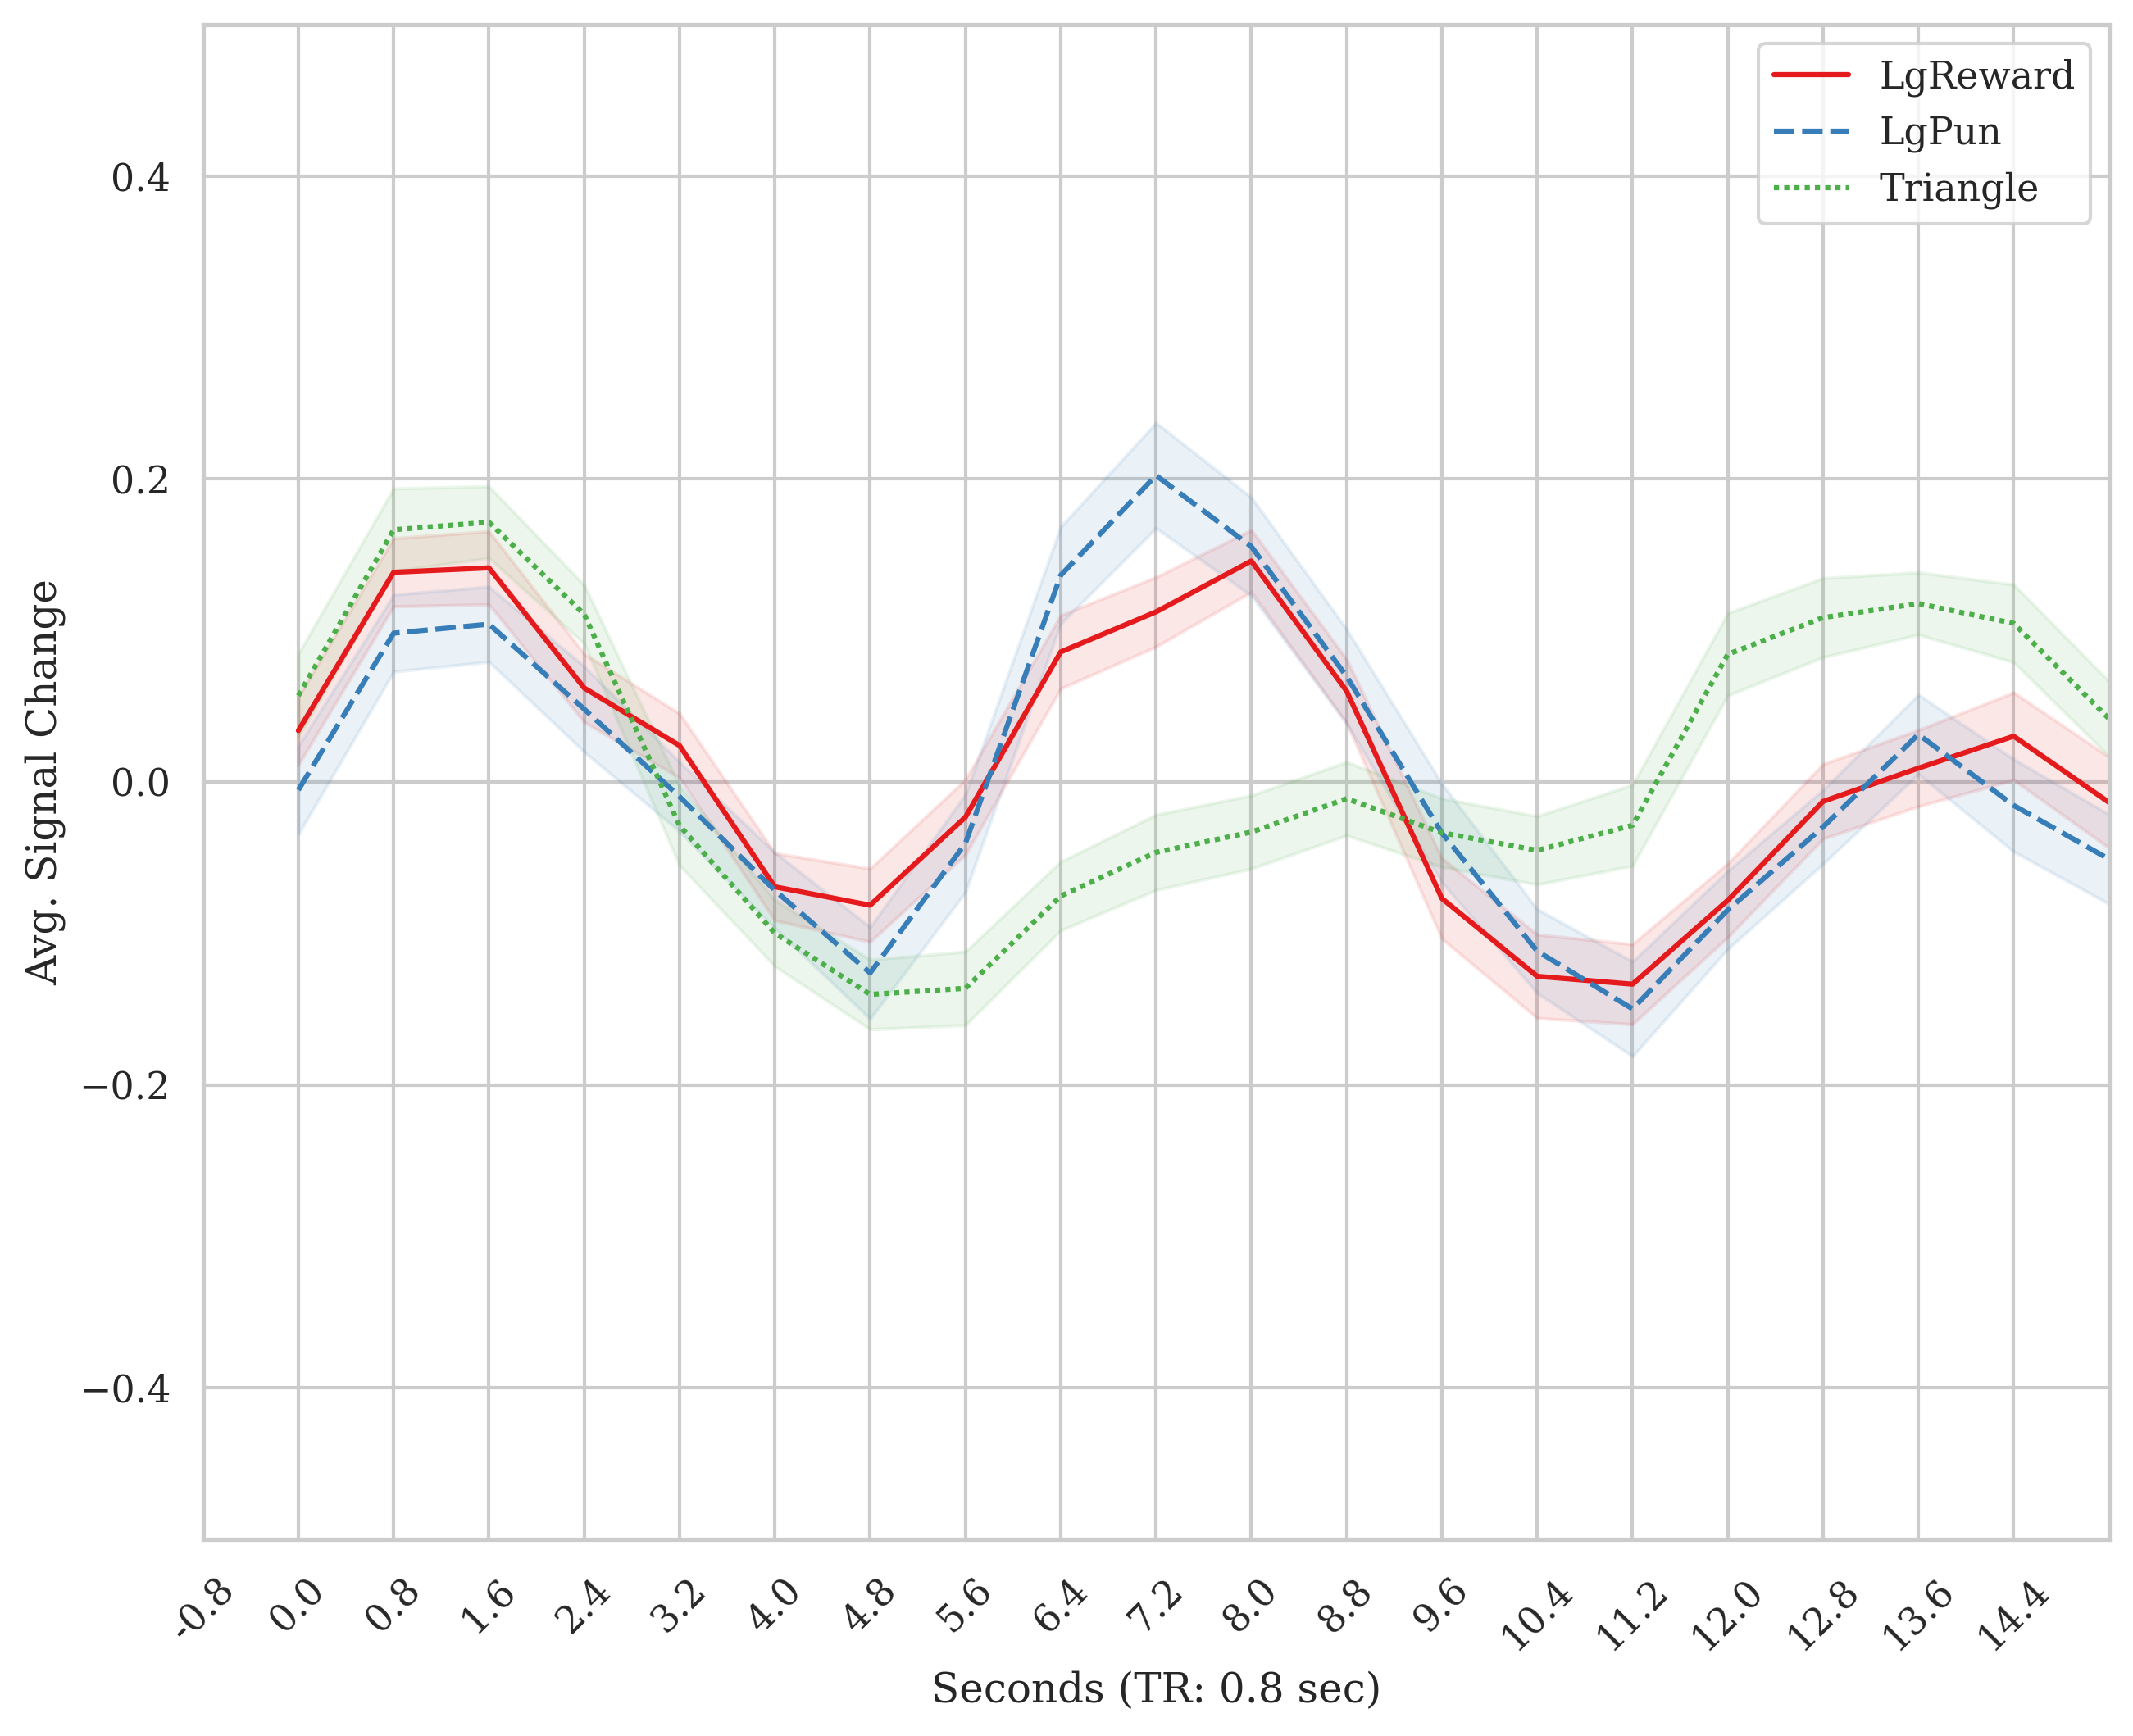

In [72]:
conditions = ['LgReward','LgPun', 'Triangle']
delay=20
dfs = []
df_siemens = extract_postcue_trs_for_conditions(events_data=beh_subset, onset=onset_time, trial_name=cond_type,
                                        bold_tr=tr, bold_vols=volumes, conditions=conditions, tr_delay=delay, 
                                        time_series=time_series_simens)
plot_responses(df=df_siemens,tr=tr, delay=delay, save_path=None,style='whitegrid', 
                   show_plot=True, ylim=(-.5, .5), plt_hrf = None)

# Philips TR-by-TR

In [79]:
philips_dat=os.path.join(data_dir,'philips')
run = '01'
n = 50
# select paths
philis_bold=glob(f'{philips_dat}/**/ses-{session}/func/*_run-{run}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
philips_beh=glob(f'{philips_dat}/**/ses-{session}/func/*_run-{run}_events.tsv')
len(philis_bold),len(philips_beh)

(50, 50)

In [80]:
start = time.time()
subset_paths = philis_bold[0:n]
time_series_philips, mask_coord = extract_time_series(bold_paths=subset_paths, roi_type='coords', 
                                              
                                              roi_coords=left_motor_neurosynth,
                                              
                                              radius_mm=sphere,bold_tr=tr,fwhm_smooth=fwhm_smooth, 
                                              high_pass_sec=filter_freq,detrend=True)
print(f'runtime: {((time.time())-start)/60}')

runtime: 20.09522927204768


In [81]:
np.array(time_series_philips).shape

(50, 403, 1)

In [82]:
beh_subset = philips_beh[0:n]

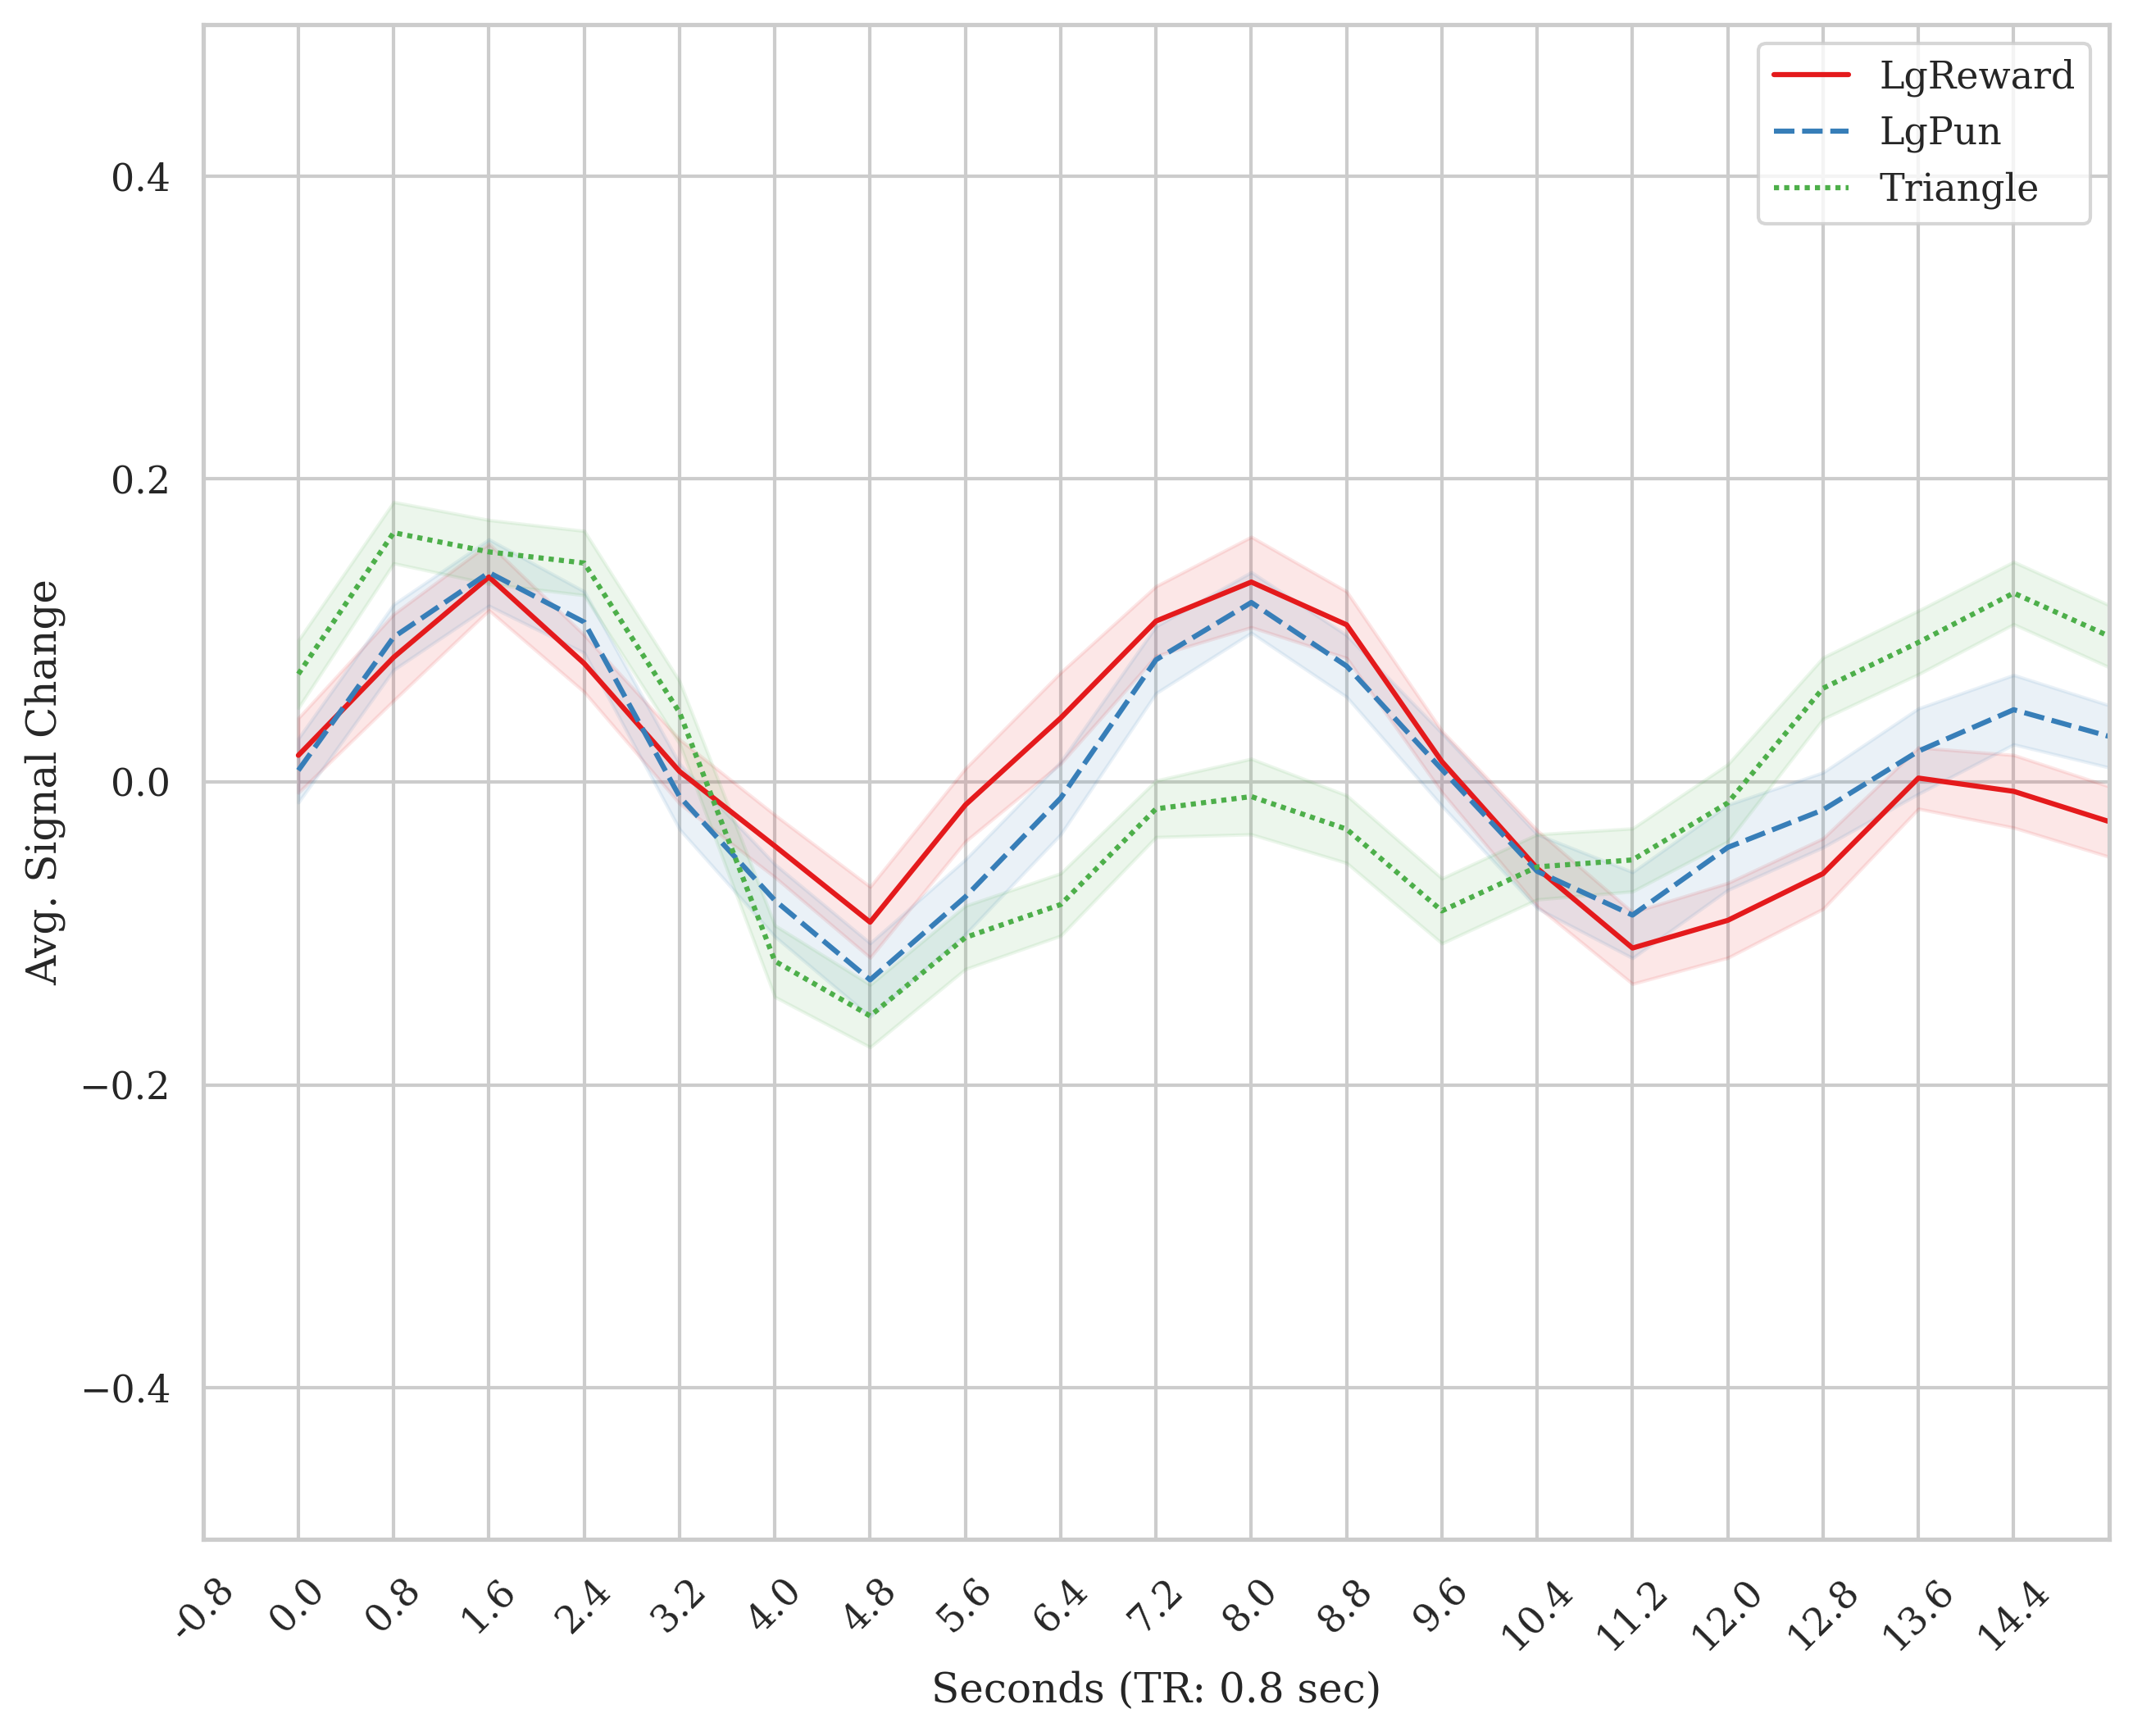

In [83]:
conditions = ['LgReward','LgPun', 'Triangle']
delay=20
dfs = []
df_philips = extract_postcue_trs_for_conditions(events_data=beh_subset, onset=onset_time, trial_name=cond_type,
                                        bold_tr=tr, bold_vols=volumes, conditions=conditions, tr_delay=delay, 
                                        time_series=time_series_philips)
plot_responses(df=df_philips,tr=tr, delay=delay, save_path=None,style='whitegrid', 
                   show_plot=True, ylim=(-.5, .5), plt_hrf = None)